# Feature Selection
"Two variables are **redundant** if they present the same impact over the ongoing discovery process"

"A variable is **irrelevant** if it is not useful for discriminating amongst target variables"

## Heart Failure Dataset

### Imports and data loading

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC, SMOTE
import csv
import numpy as np
import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

y = data.pop('DEATH_EVENT')
X = data

data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


### Redundancy & Variance analysis

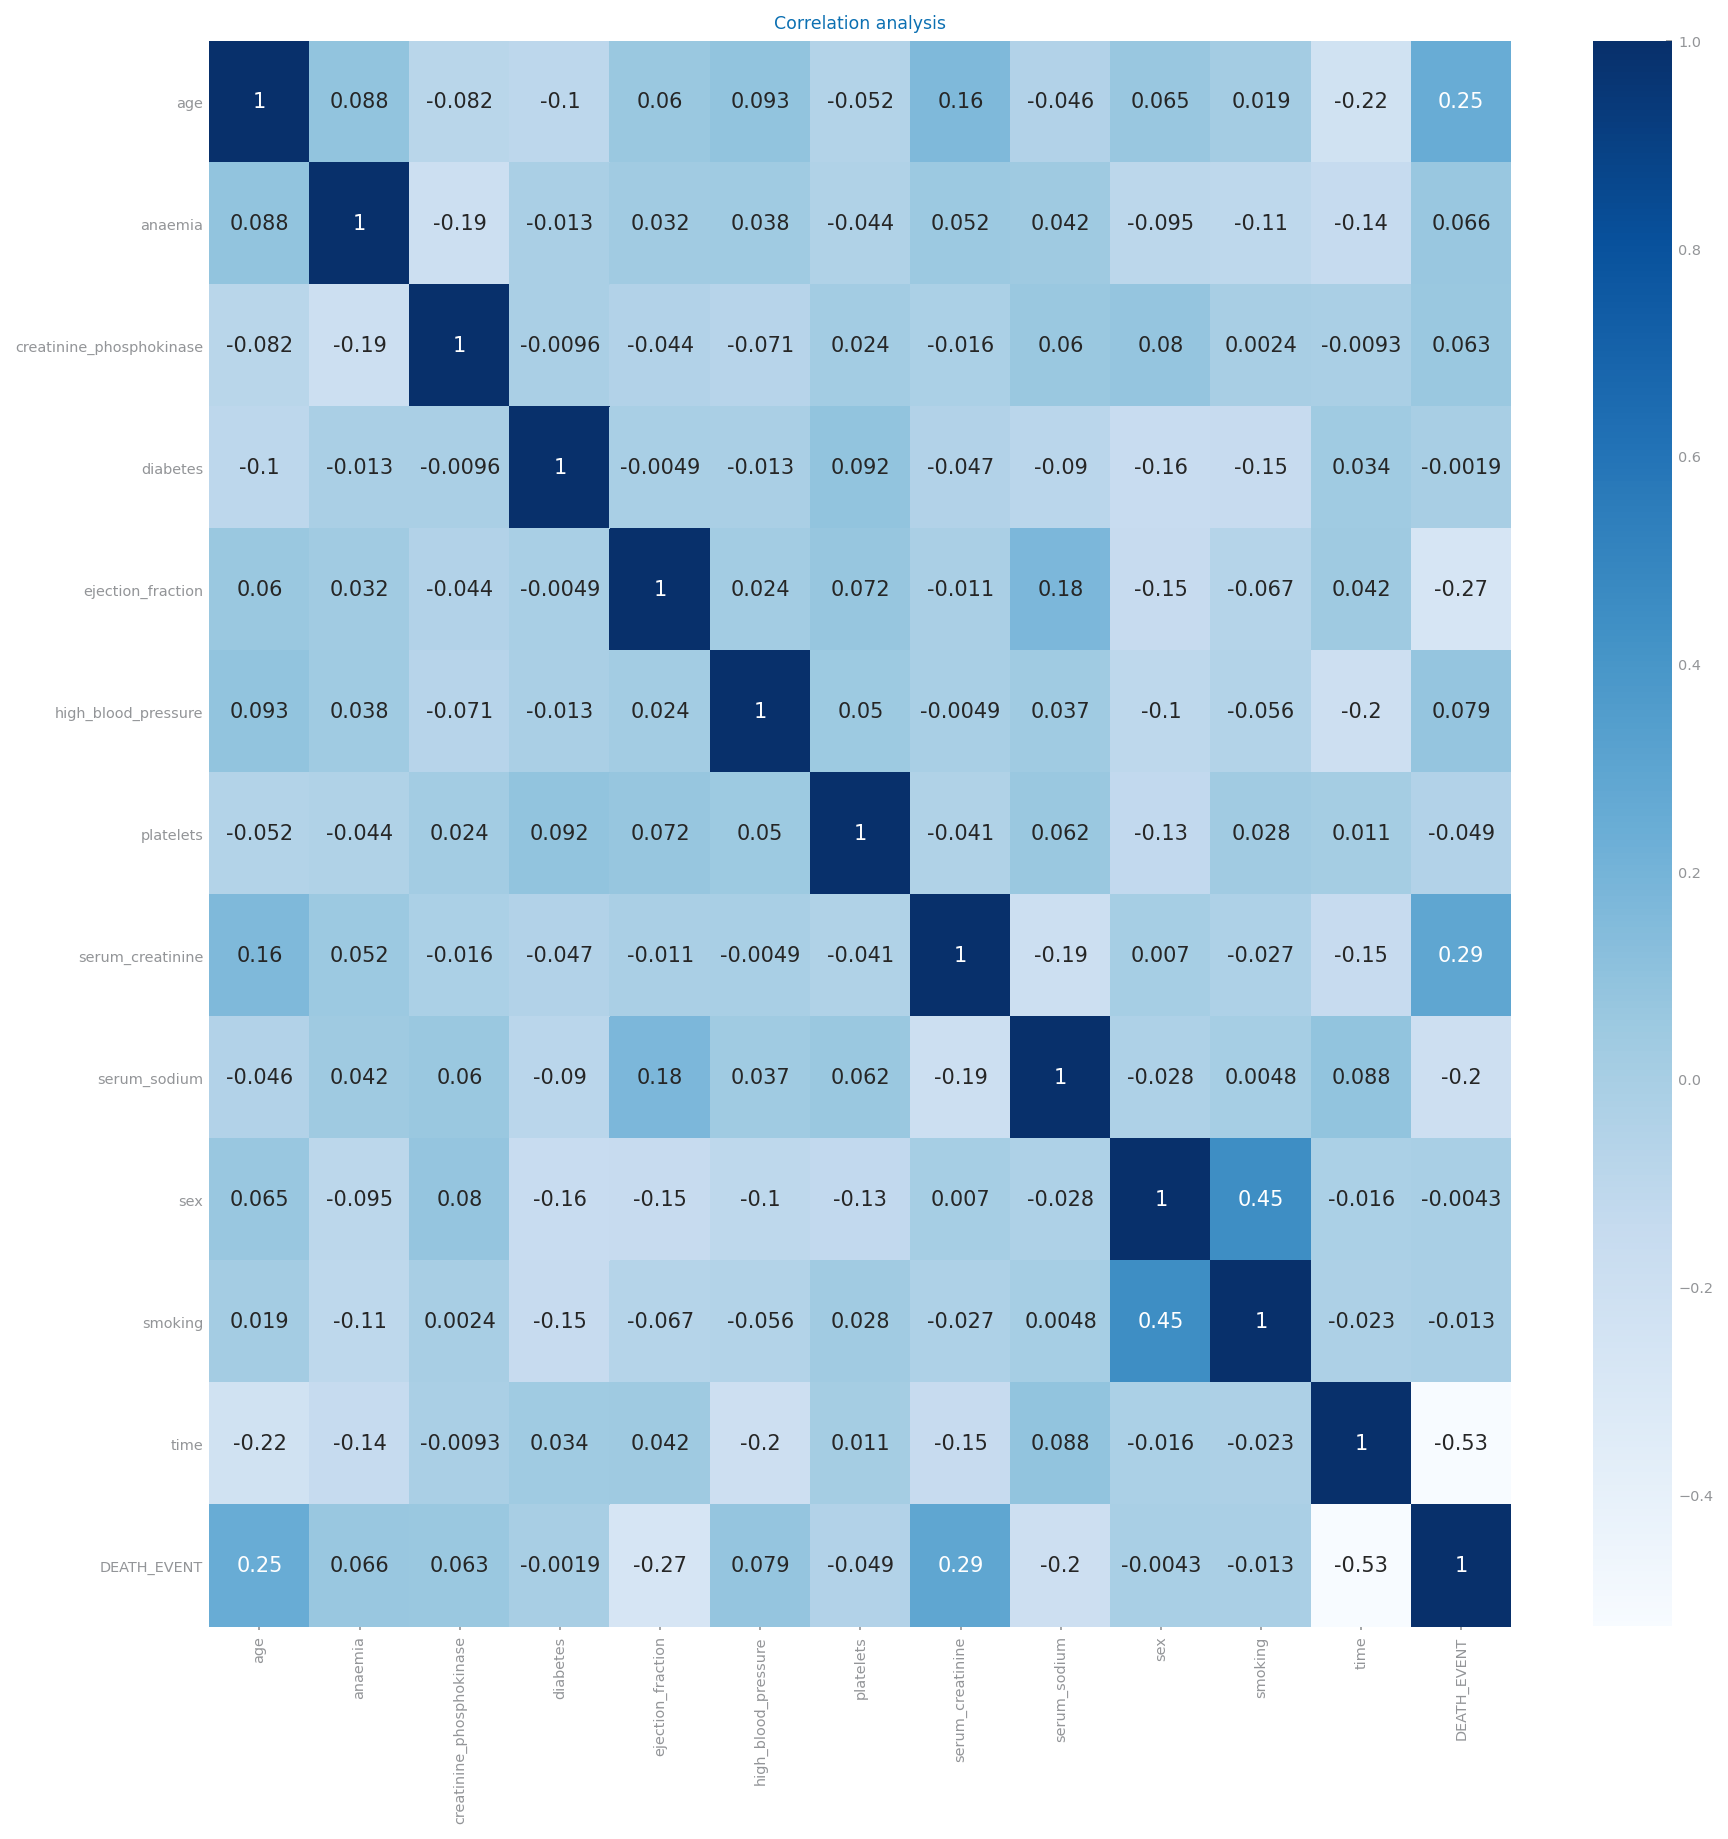

In [33]:
fig = plt.figure(figsize=[14,14])
corr_mtx = data.corr()
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

In terms of **redundancy** we didn't really note any highly correlated variables. The highest correlation is between smoking and sex, but even then the correlation didn't even surpass the 0.45

age  -  141.48648290797084
anaemia  -  0.2461224214944669
creatinine_phosphokinase  -  941458.5714574311
diabetes  -  0.2441022648200937
ejection_fraction  -  140.06345536576063
high_blood_pressure  -  0.2286143969832332
platelets  -  9565668749.44888
serum_creatinine  -  1.070211072703192
serum_sodium  -  19.469955781015
sex  -  0.22861439698323285
smoking  -  0.21871562927880447
time  -  6023.96527575139


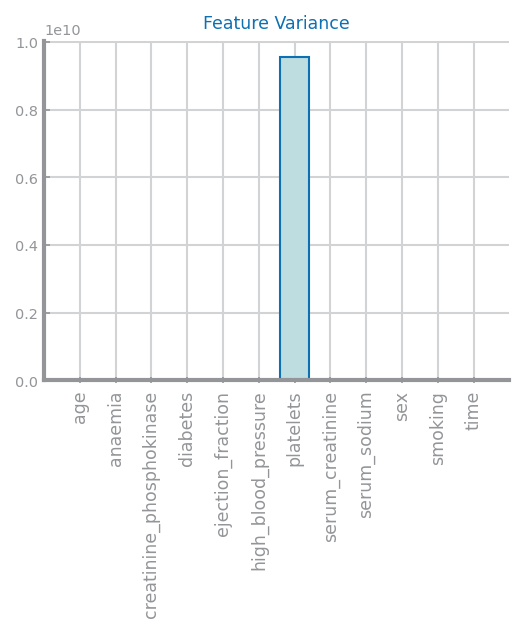

In [28]:
x_fs = []
y_fs = []
for i in data.columns:
    x_fs.append(data[i].var())
    y_fs.append(i)
    
plt.figure()
ds.bar_chart(y_fs, x_fs, title='Feature Variance')
plt.xticks(rotation=90)

for i in data.columns:
    print(i, " - ", data[i].var())

All of our variables present some variance, although this is hard to analyze due to them not being scaled. This will be easier to see on the scaled versions of this dataset

### Univariate Selection
"Statistical tests can be used to select those features that have the strongest relationship with the output variable." - https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. - https://scikit-learn.org/stable/modules/feature_selection.html

#### Pearson/Point-Biserial Correlation - Filter
"We check the absolute value of the **Pearson’s** correlation between the target and numerical features in our dataset. We keep the top n features based on this criterion." - https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

In [2]:
def cor_selector(X, y,threshold):
    cor_list = []
    feature_name = X.columns.tolist()
    
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))].columns.tolist()
    
    # remove features that have an absolute correlation value lower than the threshold
    temp_cor_list = []
    temp_cor_feature = []
    
    for i in range(0,len(cor_feature)):
        if(abs(cor_list[i]) > threshold):
            temp_cor_list.append(cor_list[i])
            temp_cor_feature.append(cor_feature[i])
        #else:
        #    print(cor_list[i])
        #    print(cor_feature[i])
    
    cor_list = temp_cor_list
    cor_feature = temp_cor_feature
        
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [3]:
threshold = 0.15

cor_support, cor_feature = cor_selector(X, y,threshold)
print(str(len(cor_feature)), 'Selected Features')
print(cor_feature)

5 Selected Features
['diabetes', 'creatinine_phosphokinase', 'serum_sodium', 'age', 'time']


In [4]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in cor_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_pearson.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,diabetes,serum_sodium,time,DEATH_EVENT
0,75.0,582,0,130,4,1
1,55.0,7861,0,136,6,1
2,65.0,146,0,129,7,1
3,50.0,111,0,137,7,1
4,65.0,160,1,116,8,1


#### ANOVA 
ANOVA is an acronym for “analysis of variance” and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not.

In [5]:
anova_selector = SelectKBest(f_classif)
anova_selector.fit(X, y)
anova_support = anova_selector.get_support()
anova_feature = X.loc[:,anova_support].columns.tolist()
print(str(len(anova_feature)), 'selected features')
print(anova_feature)

10 selected features
['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'smoking', 'time']


In [6]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in anova_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_anova.csv', index=False)
store_data.head()

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,time,DEATH_EVENT
0,75.0,0,582,20,1,265000.00,1.9,130,0,4,1
1,55.0,0,7861,38,0,263358.03,1.1,136,0,6,1
2,65.0,0,146,20,0,162000.00,1.3,129,1,7,1
3,50.0,1,111,20,0,210000.00,1.9,137,0,7,1
4,65.0,1,160,20,0,327000.00,2.7,116,0,8,1


#### Recursive Feature Elimination (WIth SVR) - Wrapper
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. 

In [7]:
estimator = SVR(kernel="linear")

rfe_selector = RFE(estimator=estimator)
rfe_selector.fit(X, y)

rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

6 selected features
['anaemia', 'high_blood_pressure', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking']


In [8]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in rfe_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_rfe.csv', index=False)
store_data.head()

,anaemia,high_blood_pressure,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,0,1,1.9,130,1,0,1
1,0,0,1.1,136,1,0,1
2,0,0,1.3,129,1,1,1
3,1,0,1.9,137,1,0,1
4,1,0,2.7,116,0,0,1


#### Chi-Squared - Filter
"We calculate the chi-square metric between the target and the numerical variable and only select the variable with the maximum chi-squared values." - https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

In [9]:
chi_selector = SelectKBest(chi2)
chi_selector.fit(X, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

10 selected features
['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'smoking', 'time']


In [10]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in chi_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_chi.csv', index=False)
store_data.head()

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,time,DEATH_EVENT
0,75.0,0,582,20,1,265000.00,1.9,130,0,4,1
1,55.0,0,7861,38,0,263358.03,1.1,136,0,6,1
2,65.0,0,146,20,0,162000.00,1.3,129,1,7,1
3,50.0,1,111,20,0,210000.00,1.9,137,0,7,1
4,65.0,1,160,20,0,327000.00,2.7,116,0,8,1


#### Lasso
Allegedly really good for when you have both categorical and numeric features - https://datascience.stackexchange.com/questions/68792/feature-selection-for-data-with-both-continuous-and-categorical-features

This is an Embedded method. As said before, Embedded methods use algorithms that have built-in feature selection methods.

For example, Lasso and RF have their own feature selection methods. Lasso Regularizer forces a lot of feature weights to be zero.

In [11]:
estimator = SVR(kernel="linear")

embeded_lr_selector = SelectFromModel(estimator, max_features=10)
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
print(embeded_lr_feature)

2 selected features
['age', 'time']


In [12]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in embeded_lr_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_lasso.csv', index=False)
store_data.head()

,age,time,DEATH_EVENT
0,75.0,4,1
1,55.0,6,1
2,65.0,7,1
3,50.0,7,1
4,65.0,8,1


#### Mixing

In [13]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':X.columns.tolist(), 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'ANOVA': anova_support, 'Lasso': embeded_lr_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(12)

,Feature,Pearson,Chi-2,RFE,ANOVA,Lasso,Total
1,time,True,True,False,True,True,4
2,serum_sodium,True,True,True,True,False,4
3,age,True,True,False,True,True,4
4,smoking,False,True,True,True,False,3
5,serum_creatinine,False,True,True,True,False,3
6,high_blood_pressure,False,True,True,True,False,3
7,creatinine_phosphokinase,True,True,False,True,False,3
8,anaemia,False,True,True,True,False,3
9,platelets,False,True,False,True,False,2
10,ejection_fraction,False,True,False,True,False,2


In [14]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

feature_selection_df.drop(feature_selection_df[feature_selection_df.Total < 4].index, inplace=True)

store_data = data.copy()
for col in data.columns.tolist():
    if col not in feature_selection_df['Feature'].tolist() and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_mixed.csv', index=False)
store_data.head()

,age,serum_sodium,time,DEATH_EVENT
0,75.0,130,4,1
1,55.0,136,6,1
2,65.0,129,7,1
3,50.0,137,7,1
4,65.0,116,8,1


### Feature Importance
"Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable."

"Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top features for the dataset."

-https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

[0.09468927 0.02352967 0.0731177  0.0300104  0.12611802 0.02397215
 0.07265421 0.11760592 0.08081258 0.02535949 0.02834516 0.30378544]


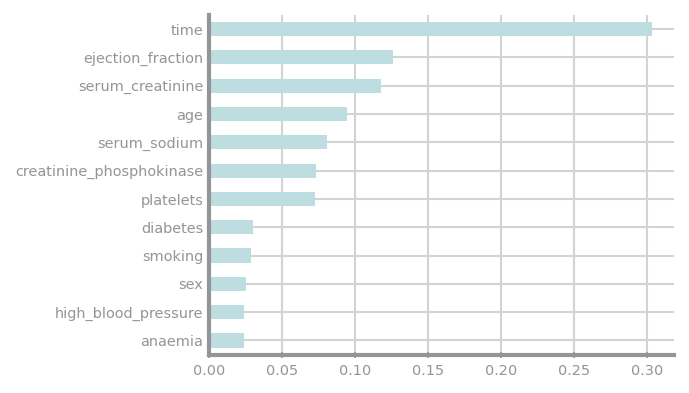

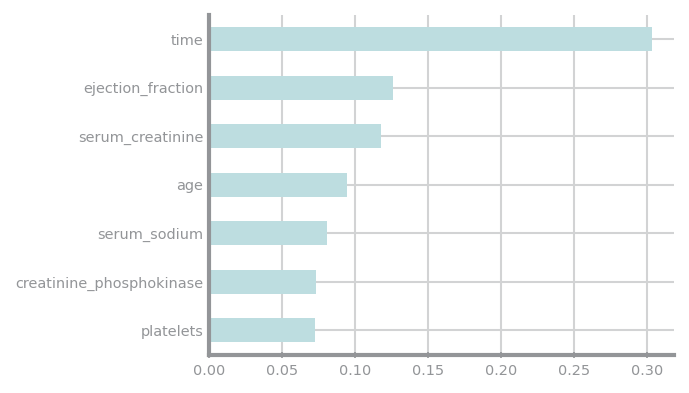

In [15]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

y = data.pop('DEATH_EVENT')
X = data

model = ExtraTreesClassifier()
model.fit(X,y)

print(model.feature_importances_) #Use inbuilt class feature_importances of tree based classifiers

#Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh')
plt.show()

#Remove features with importance under 0.05
feat_importances.drop(feat_importances[feat_importances.values < 0.05].index, inplace=True)

feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh')
plt.show()

In [16]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in feat_importances.index.tolist() and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/importance/HR_extraTreeClassifier.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,75.0,582,20,265000.00,1.9,130,4,1
1,55.0,7861,38,263358.03,1.1,136,6,1
2,65.0,146,20,162000.00,1.3,129,7,1
3,50.0,111,20,210000.00,1.9,137,7,1
4,65.0,160,20,327000.00,2.7,116,8,1


### Correlation Matrix

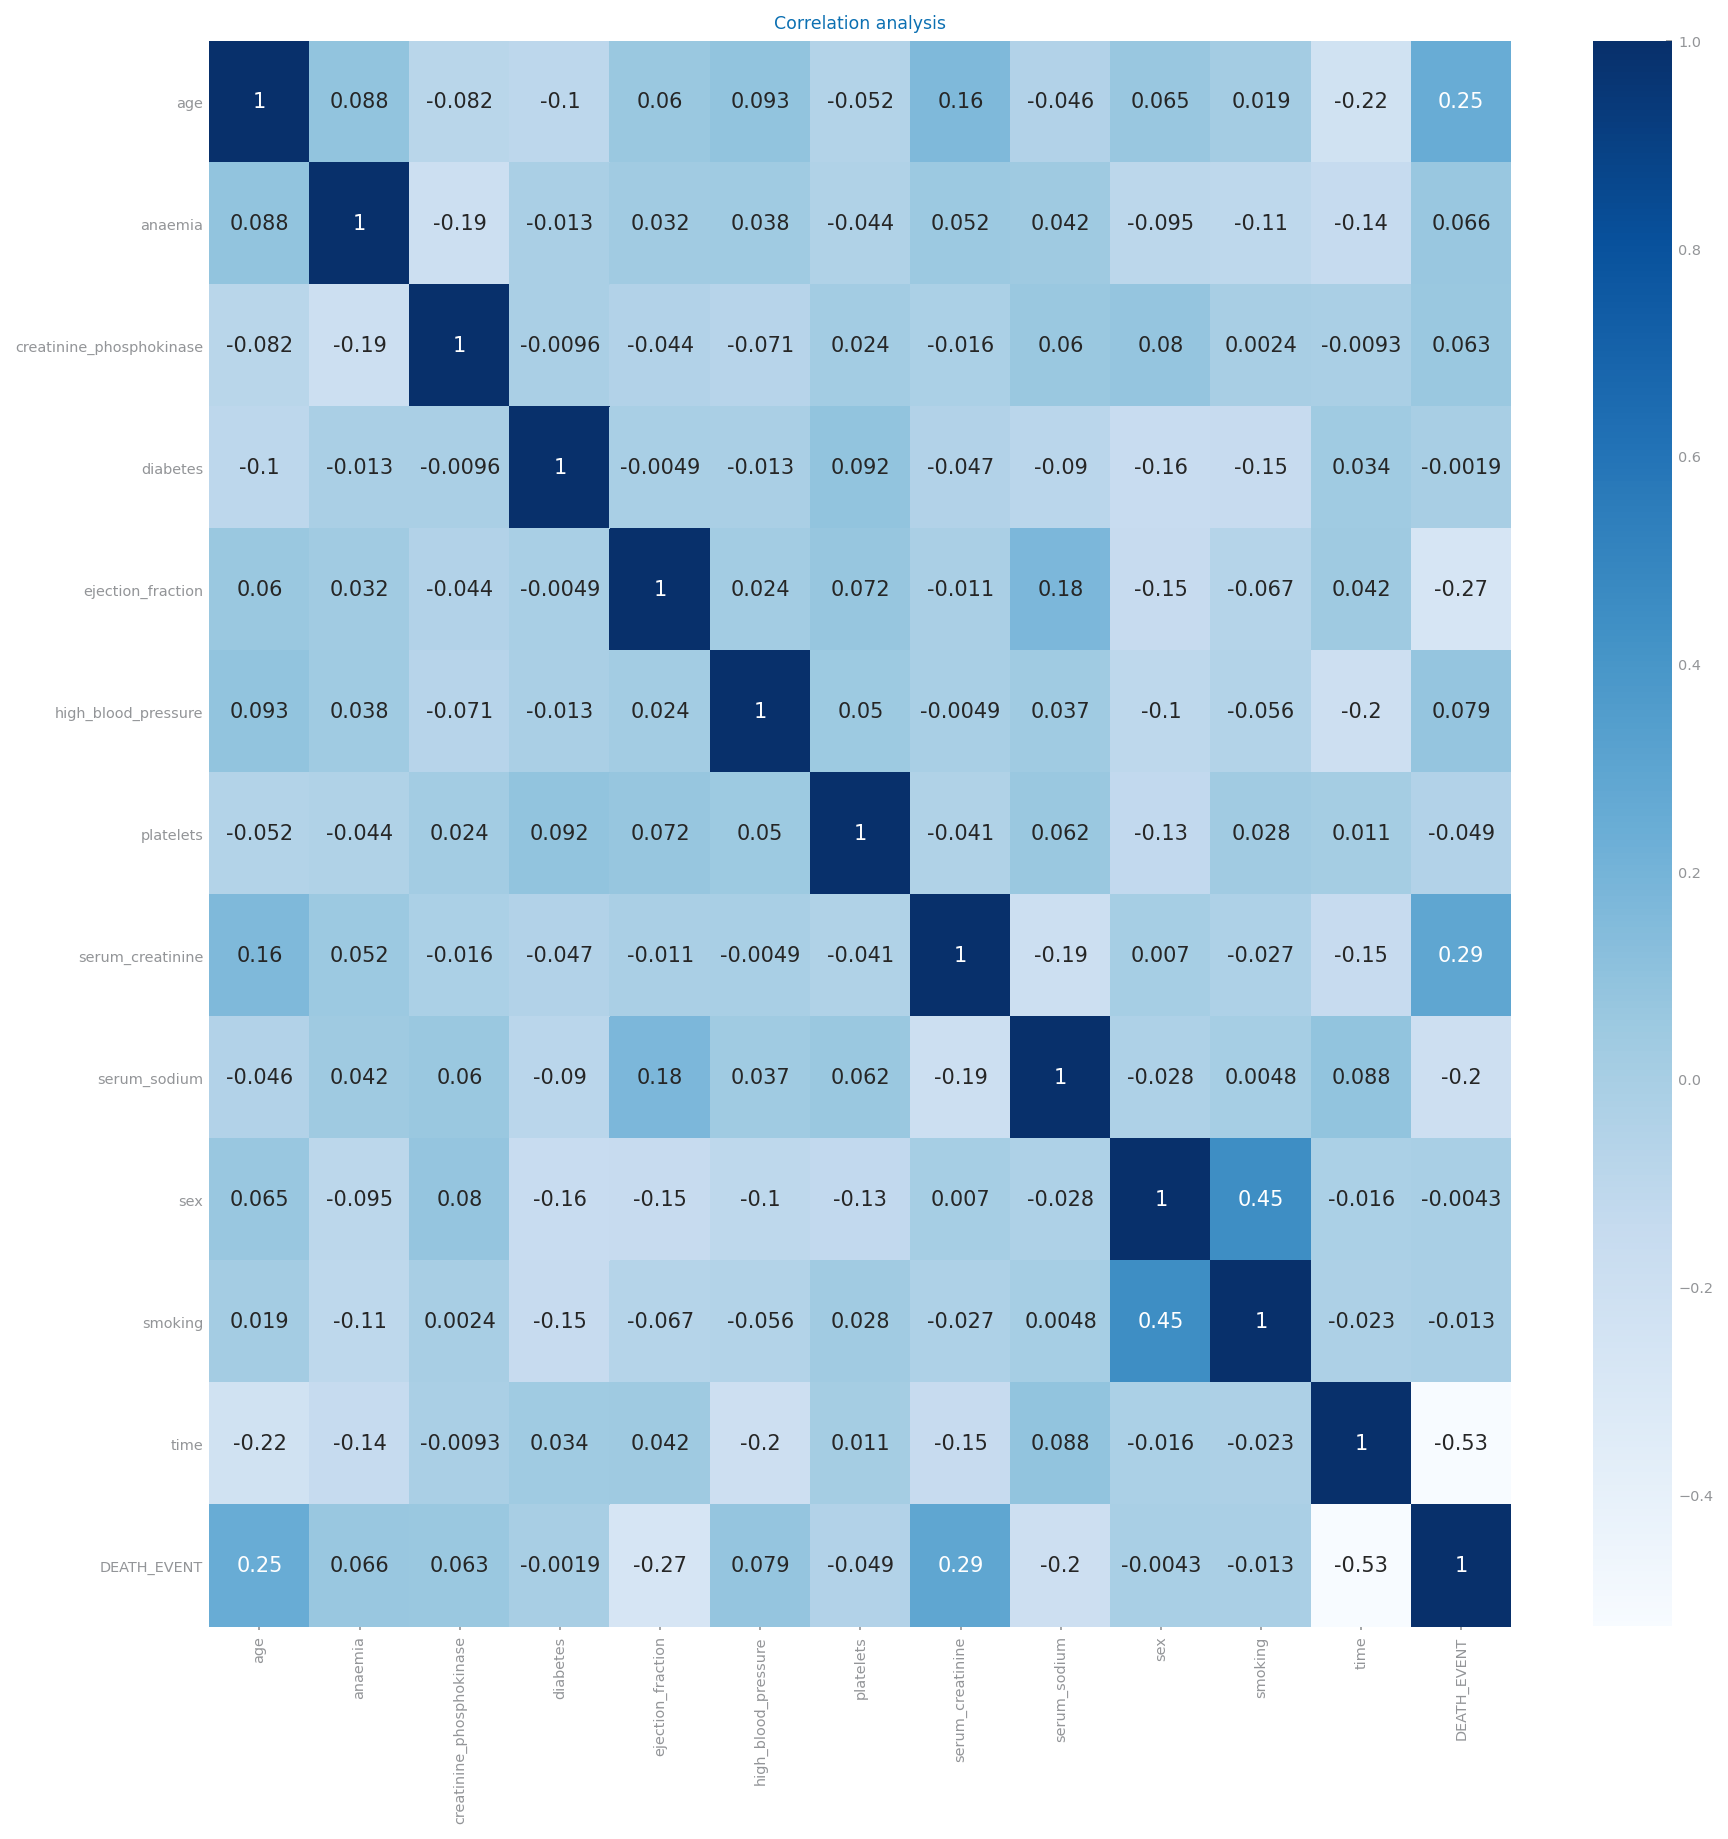

In [17]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

fig = plt.figure(figsize=[14,14])
corr_mtx = data.corr()
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

By analyzing this heatmap we can note that there are two specific variables that correlate very little to the target variable - DEATH_EVENT

These are - **diabetes** and **sex**

In [18]:
corr_mtx = data.corr()
corr_mtx.drop(corr_mtx.head(12).index,inplace=True) 

temp_feature = []

#Remove all features whose correlation to our target variable is smaller than 0.01
for i in corr_mtx.columns:
    if(abs(corr_mtx[i].values) > 0.01):
        temp_feature.append(i)
        
print(str(len(temp_feature)), 'selected features (features + target)')
print(temp_feature)

11 selected features (features + target)
['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'smoking', 'time', 'DEATH_EVENT']


In [19]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

feature_selection_df.drop(feature_selection_df[feature_selection_df.Total < 3].index, inplace=True)

store_data = data.copy()
for col in data.columns.tolist():
    if col not in temp_feature:
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/correlation/HR_corr.csv', index=False)
store_data.head()

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,time,DEATH_EVENT
0,75.0,0,582,20,1,265000.00,1.9,130,0,4,1
1,55.0,0,7861,38,0,263358.03,1.1,136,0,6,1
2,65.0,0,146,20,0,162000.00,1.3,129,1,7,1
3,50.0,1,111,20,0,210000.00,1.9,137,0,7,1
4,65.0,1,160,20,0,327000.00,2.7,116,0,8,1


<br/>
<br/>
<br/>
<br/>
<br/>

## Heart Failure Dataset (Normalized)

### Imports and data loading

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC, SMOTE
import csv
import numpy as np
import seaborn as sns

#data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

y = data.pop('DEATH_EVENT')
X = data

data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking
0,0.636364,0.071319,0.090909,0.290823,0.157303,0.485714,0.000000,0,0,1,1,0
1,0.272727,1.000000,0.363636,0.288833,0.067416,0.657143,0.007117,0,0,0,1,0
2,0.454545,0.015693,0.090909,0.165960,0.089888,0.457143,0.010676,0,0,0,1,1
3,0.181818,0.011227,0.090909,0.224148,0.157303,0.685714,0.010676,1,0,0,1,0
4,0.454545,0.017479,0.090909,0.365984,0.247191,0.085714,0.014235,1,1,0,0,0


### Redundancy & Variance analysis

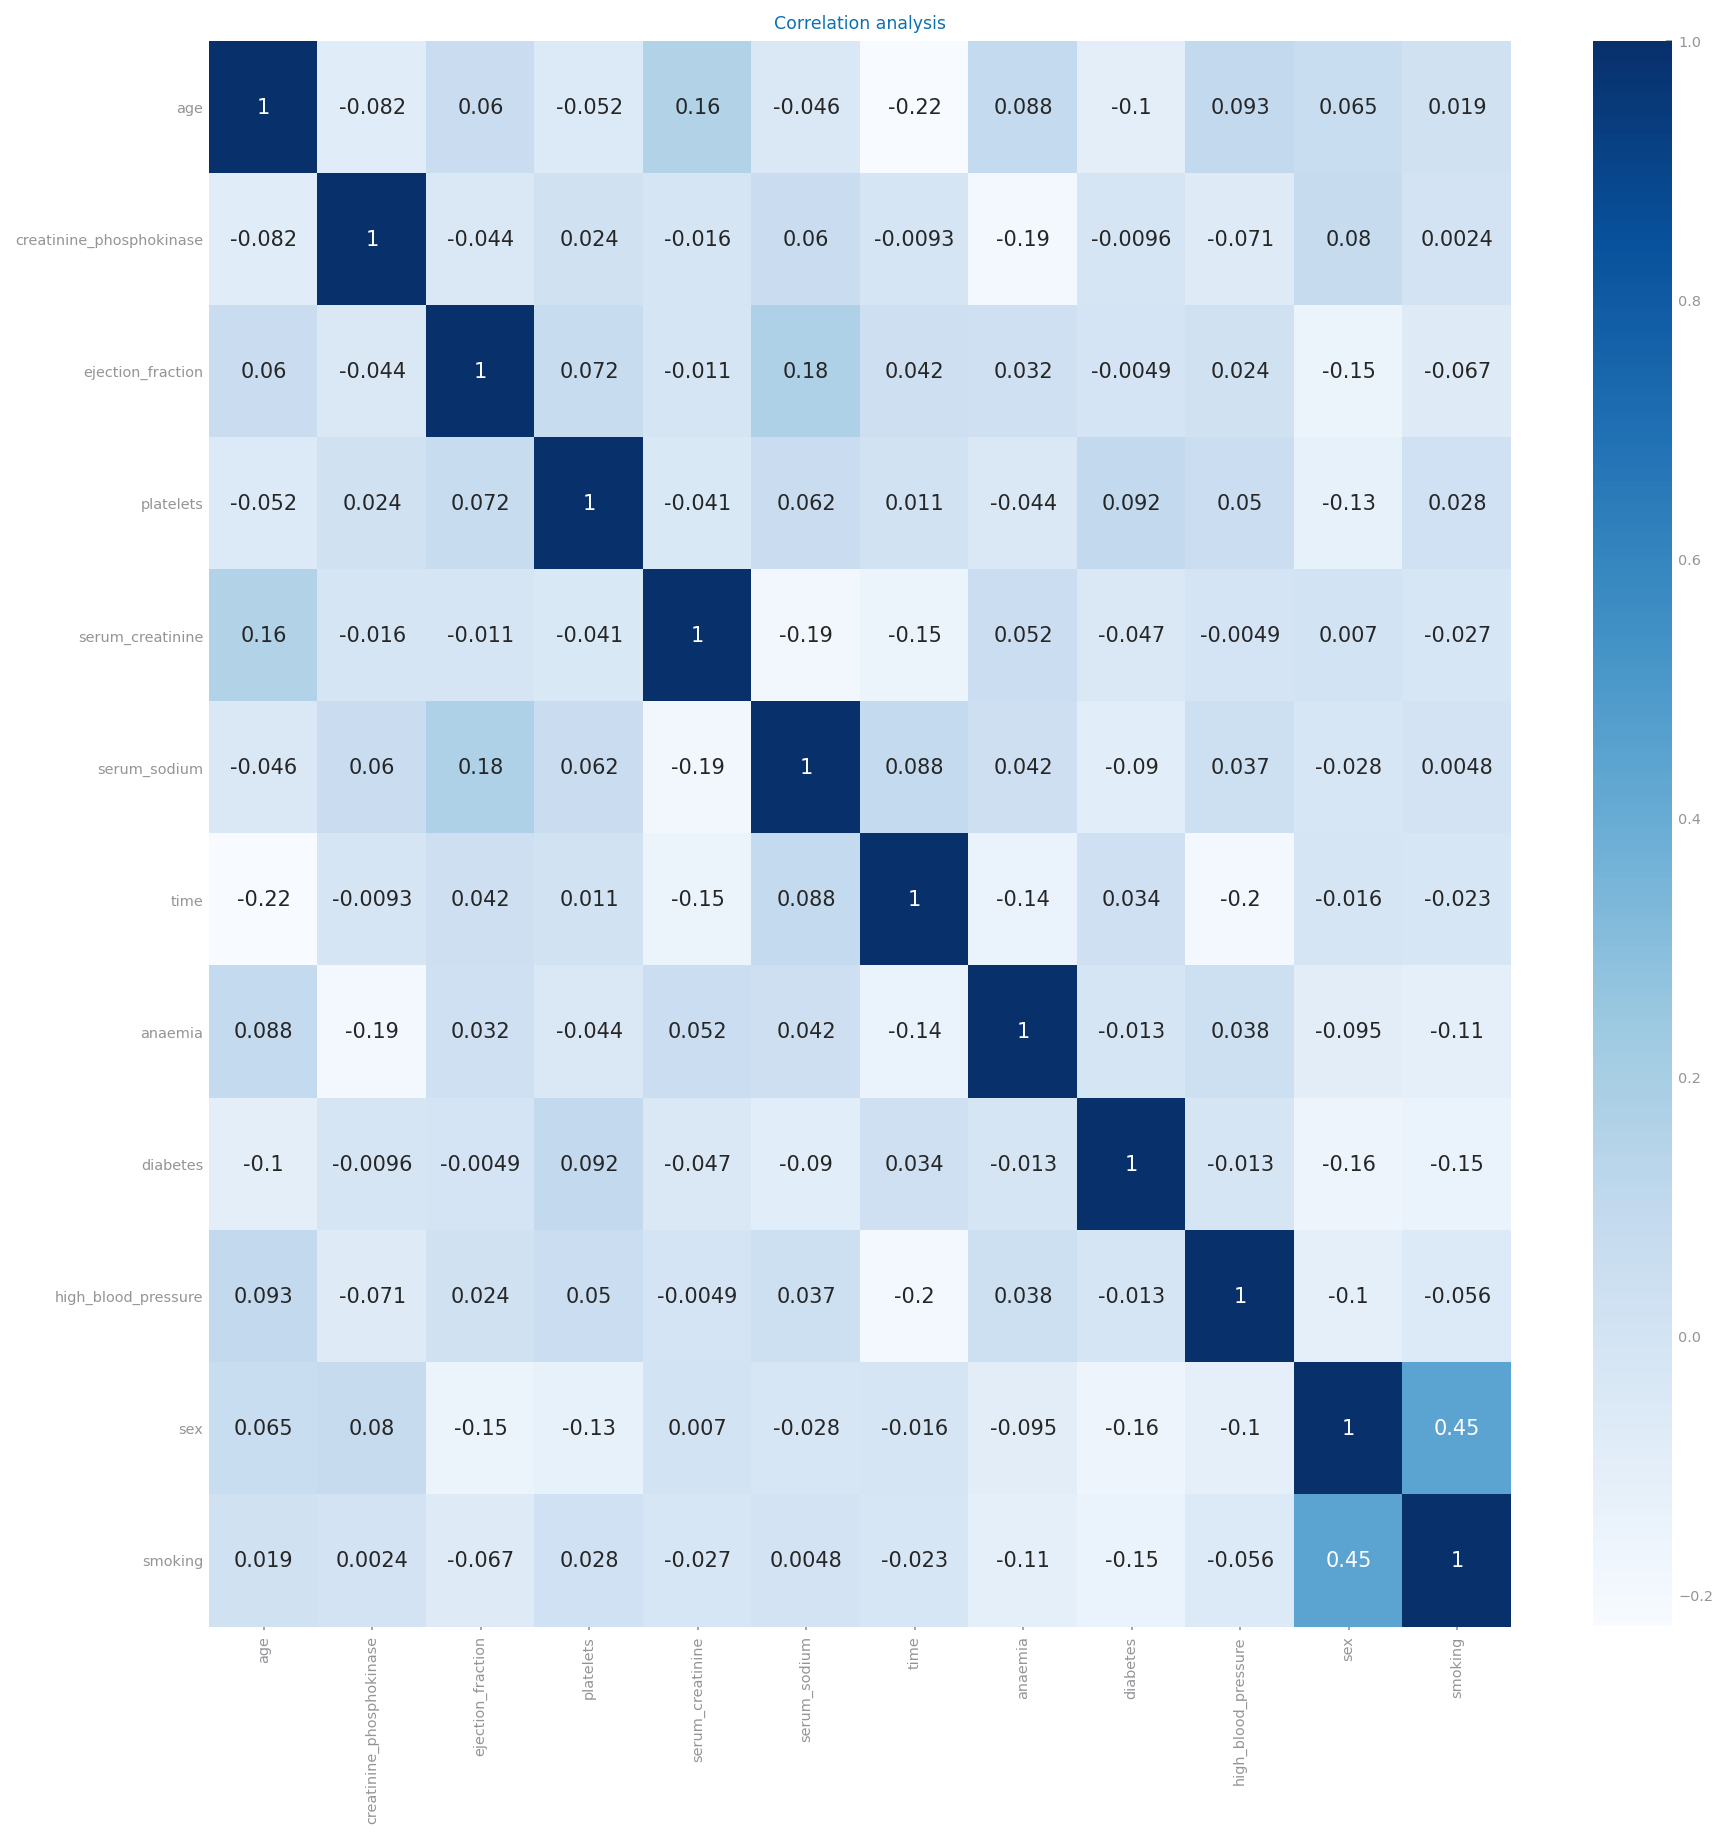

In [12]:
fig = plt.figure(figsize=[14,14])
corr_mtx = data.corr()
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

In terms of **redundancy** we didn't really note any highly correlated variables. The highest correlation is between smoking and sex, but even then the correlation didn't even surpass the 0.45

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

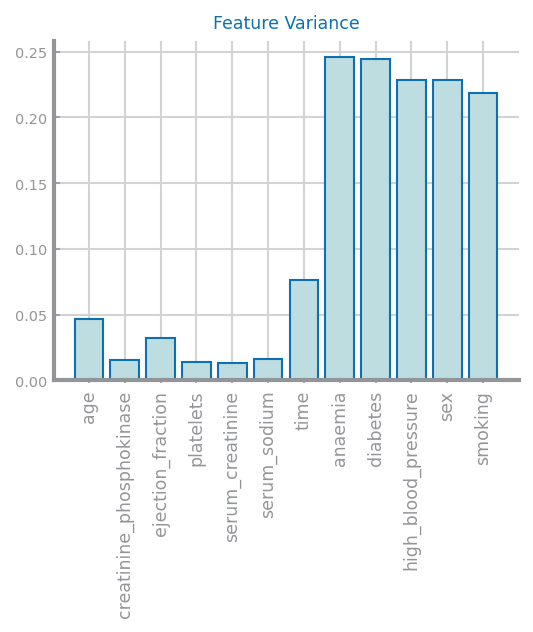

In [24]:
x_fs = []
y_fs = []
for i in data.columns:
    x_fs.append(data[i].var())
    y_fs.append(i)
    
plt.figure()
ds.bar_chart(y_fs, x_fs, title='Feature Variance')
plt.xticks(rotation=90)

All of our variables present some variance, although some do present a much smaller variation than others. Of note are **time**, **serum_sodium**, *serum_Creatinine** and **platelets**. Even still we felt they didn't warrant getting removed purely due to the lack of variance (but we'll be looking out for these)

### Univariate Selection
"Statistical tests can be used to select those features that have the strongest relationship with the output variable." - https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. - https://scikit-learn.org/stable/modules/feature_selection.html

#### Pearson/Point-Biserial Correlation - Filter
"We check the absolute value of the **Pearson’s** correlation between the target and numerical features in our dataset. We keep the top n features based on this criterion." - https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

In [21]:
def cor_selector(X, y,threshold):
    cor_list = []
    feature_name = X.columns.tolist()
    
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))].columns.tolist()
    
    # remove features that have an absolute correlation value lower than the threshold
    temp_cor_list = []
    temp_cor_feature = []
    
    for i in range(0,len(cor_feature)):
        if(abs(cor_list[i]) > threshold):
            temp_cor_list.append(cor_list[i])
            temp_cor_feature.append(cor_feature[i])
        #else:
        #    print(cor_list[i])
        #    print(cor_feature[i])
    
    cor_list = temp_cor_list
    cor_feature = temp_cor_feature
        
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [22]:
threshold = 0.15

cor_support, cor_feature = cor_selector(X, y,threshold)
print(str(len(cor_feature)), 'Selected Features')
print(cor_feature)

5 Selected Features
['diabetes', 'smoking', 'creatinine_phosphokinase', 'anaemia', 'high_blood_pressure']


In [23]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in cor_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_normalized_pearson.csv', index=False)
store_data.head()

,creatinine_phosphokinase,anaemia,diabetes,high_blood_pressure,smoking,DEATH_EVENT
0,0.071319,0,0,1,0,1
1,1.000000,0,0,0,0,1
2,0.015693,0,0,0,1,1
3,0.011227,1,0,0,0,1
4,0.017479,1,1,0,0,1


#### ANOVA 
ANOVA is an acronym for “analysis of variance” and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not.

In [24]:
anova_selector = SelectKBest(f_classif)
anova_selector.fit(X, y)
anova_support = anova_selector.get_support()
anova_feature = X.loc[:,anova_support].columns.tolist()
print(str(len(anova_feature)), 'selected features')
print(anova_feature)

10 selected features
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia', 'high_blood_pressure', 'smoking']


In [25]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in anova_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_normalized_anova.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,high_blood_pressure,smoking,DEATH_EVENT
0,0.636364,0.071319,0.090909,0.290823,0.157303,0.485714,0.000000,0,1,0,1
1,0.272727,1.000000,0.363636,0.288833,0.067416,0.657143,0.007117,0,0,0,1
2,0.454545,0.015693,0.090909,0.165960,0.089888,0.457143,0.010676,0,0,1,1
3,0.181818,0.011227,0.090909,0.224148,0.157303,0.685714,0.010676,1,0,0,1
4,0.454545,0.017479,0.090909,0.365984,0.247191,0.085714,0.014235,1,0,0,1


#### Chi-Squared - Filter
"We calculate the chi-square metric between the target and the numerical variable and only select the variable with the maximum chi-squared values." - https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

In [26]:
chi_selector = SelectKBest(chi2)
chi_selector.fit(X, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

10 selected features
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia', 'high_blood_pressure', 'smoking']


In [27]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in chi_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_normalized_chi.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,high_blood_pressure,smoking,DEATH_EVENT
0,0.636364,0.071319,0.090909,0.290823,0.157303,0.485714,0.000000,0,1,0,1
1,0.272727,1.000000,0.363636,0.288833,0.067416,0.657143,0.007117,0,0,0,1
2,0.454545,0.015693,0.090909,0.165960,0.089888,0.457143,0.010676,0,0,1,1
3,0.181818,0.011227,0.090909,0.224148,0.157303,0.685714,0.010676,1,0,0,1
4,0.454545,0.017479,0.090909,0.365984,0.247191,0.085714,0.014235,1,0,0,1


#### Recursive Feature Elimination (WIth SVR) - Wrapper
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. 

In [28]:
estimator = SVR(kernel="linear")

rfe_selector = RFE(estimator=estimator)
rfe_selector.fit(X, y)

rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

6 selected features
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']


In [29]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in rfe_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_normalized_rfe.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,0.636364,0.071319,0.090909,0.157303,0.485714,0.000000,1
1,0.272727,1.000000,0.363636,0.067416,0.657143,0.007117,1
2,0.454545,0.015693,0.090909,0.089888,0.457143,0.010676,1
3,0.181818,0.011227,0.090909,0.157303,0.685714,0.010676,1
4,0.454545,0.017479,0.090909,0.247191,0.085714,0.014235,1


#### Lasso
Allegedly really good for when you have both categorical and numeric features - https://datascience.stackexchange.com/questions/68792/feature-selection-for-data-with-both-continuous-and-categorical-features

This is an Embedded method. As said before, Embedded methods use algorithms that have built-in feature selection methods.

For example, Lasso and RF have their own feature selection methods. Lasso Regularizer forces a lot of feature weights to be zero.

In [30]:
estimator = SVR(kernel="linear")

embeded_lr_selector = SelectFromModel(estimator, max_features=10)
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
print(embeded_lr_feature)

5 selected features
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'time']


In [31]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in embeded_lr_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_normalized_lasso.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,time,DEATH_EVENT
0,0.636364,0.071319,0.090909,0.157303,0.000000,1
1,0.272727,1.000000,0.363636,0.067416,0.007117,1
2,0.454545,0.015693,0.090909,0.089888,0.010676,1
3,0.181818,0.011227,0.090909,0.157303,0.010676,1
4,0.454545,0.017479,0.090909,0.247191,0.014235,1


#### Mixing

In [32]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':X.columns.tolist(), 'Pearson':cor_support, 'Chi-2':chi_support, 'ANOVA': anova_support, 'RFE':rfe_support, 'Lasso': embeded_lr_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(12)

,Feature,Pearson,Chi-2,ANOVA,RFE,Lasso,Total
1,creatinine_phosphokinase,True,True,True,True,True,5
2,time,False,True,True,True,True,4
3,serum_creatinine,False,True,True,True,True,4
4,ejection_fraction,False,True,True,True,True,4
5,age,False,True,True,True,True,4
6,smoking,True,True,True,False,False,3
7,serum_sodium,False,True,True,True,False,3
8,high_blood_pressure,True,True,True,False,False,3
9,anaemia,True,True,True,False,False,3
10,platelets,False,True,True,False,False,2


In [33]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

feature_selection_df.drop(feature_selection_df[feature_selection_df.Total < 4].index, inplace=True)

store_data = data.copy()
for col in data.columns.tolist():
    if col not in feature_selection_df['Feature'].tolist() and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_normalized_mixed.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,time,DEATH_EVENT
0,0.636364,0.071319,0.090909,0.157303,0.000000,1
1,0.272727,1.000000,0.363636,0.067416,0.007117,1
2,0.454545,0.015693,0.090909,0.089888,0.010676,1
3,0.181818,0.011227,0.090909,0.157303,0.010676,1
4,0.454545,0.017479,0.090909,0.247191,0.014235,1


### Feature Importance
"Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable."

"Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top features for the dataset."

-https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

[0.09866686 0.07810654 0.12561246 0.07129231 0.11600229 0.08776531
 0.29565696 0.02241304 0.02997394 0.02409331 0.02424103 0.02617594]


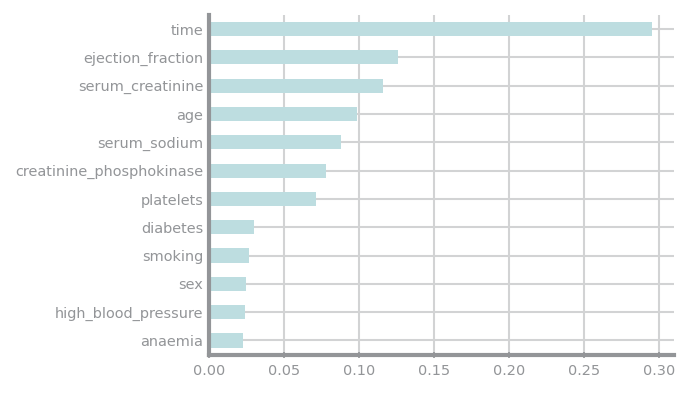

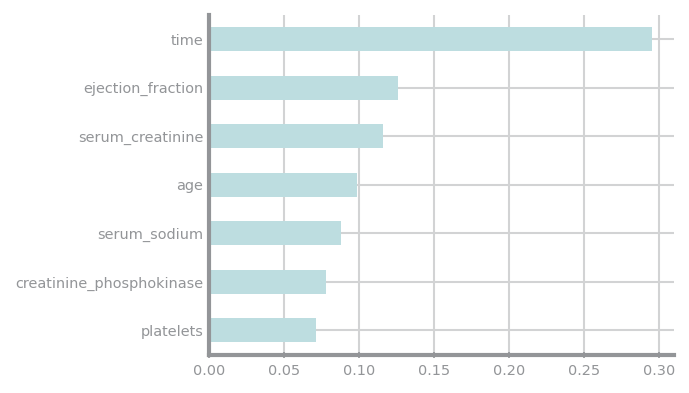

In [34]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

y = data.pop('DEATH_EVENT')
X = data

model = ExtraTreesClassifier()
model.fit(X,y)

print(model.feature_importances_) #Use inbuilt class feature_importances of tree based classifiers

#Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh')
plt.show()

#Remove features with importance under 0.05
feat_importances.drop(feat_importances[feat_importances.values < 0.05].index, inplace=True)

feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh')
plt.show()

In [35]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in feat_importances.index.tolist() and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/importance/HR_normalized_extraTreeClassifier.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,0.636364,0.071319,0.090909,0.290823,0.157303,0.485714,0.000000,1
1,0.272727,1.000000,0.363636,0.288833,0.067416,0.657143,0.007117,1
2,0.454545,0.015693,0.090909,0.165960,0.089888,0.457143,0.010676,1
3,0.181818,0.011227,0.090909,0.224148,0.157303,0.685714,0.010676,1
4,0.454545,0.017479,0.090909,0.365984,0.247191,0.085714,0.014235,1


### Correlation Matrix

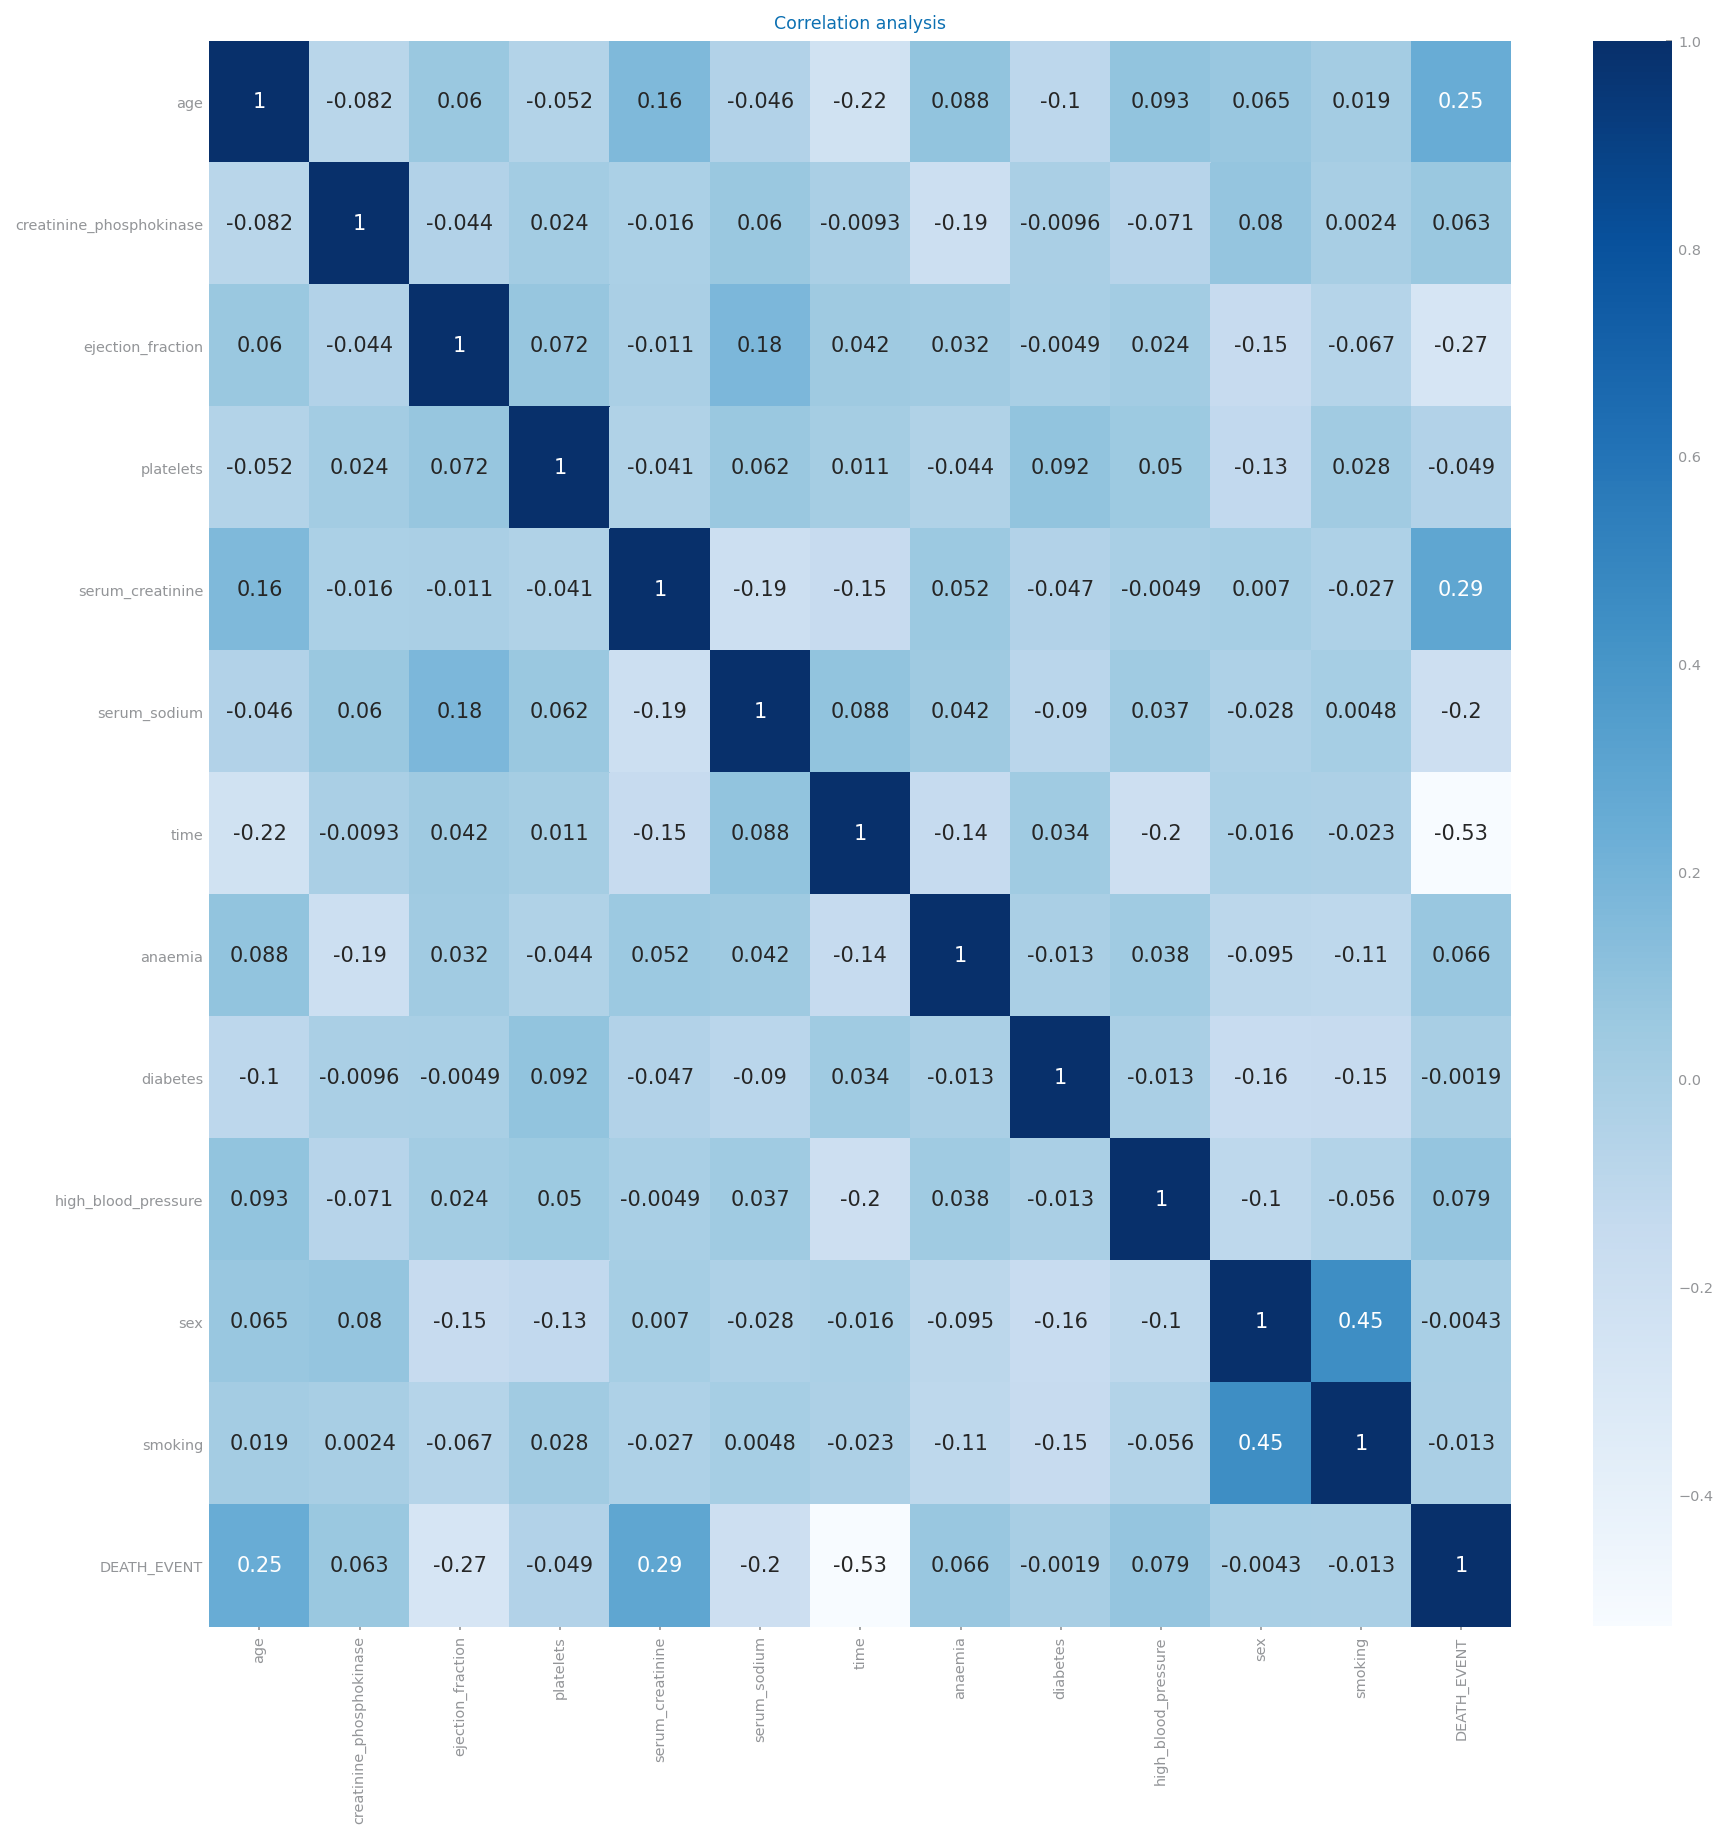

In [36]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

fig = plt.figure(figsize=[14,14])
corr_mtx = data.corr()
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

By analyzing this heatmap we can note that there are two specific variables that correlate very little to the target variable - DEATH_EVENT

These are - **diabetes** and **sex**

In [37]:
corr_mtx = data.corr()
corr_mtx.drop(corr_mtx.head(12).index,inplace=True) 

temp_feature = []

#Remove all features whose correlation to our target variable is smaller than 0.01
for i in corr_mtx.columns:
    if(abs(corr_mtx[i].values) > 0.01):
        temp_feature.append(i)
        
print(str(len(temp_feature)), 'selected features (features + target)')
print(temp_feature)

11 selected features (features + target)
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']


In [38]:
data = pd.read_csv('../datasets/hf_scaled/HF_normalized.csv')

feature_selection_df.drop(feature_selection_df[feature_selection_df.Total < 3].index, inplace=True)

store_data = data.copy()
for col in data.columns.tolist():
    if col not in temp_feature:
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/correlation/HR_normalized_corr.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,high_blood_pressure,smoking,DEATH_EVENT
0,0.636364,0.071319,0.090909,0.290823,0.157303,0.485714,0.000000,0,1,0,1
1,0.272727,1.000000,0.363636,0.288833,0.067416,0.657143,0.007117,0,0,0,1
2,0.454545,0.015693,0.090909,0.165960,0.089888,0.457143,0.010676,0,0,1,1
3,0.181818,0.011227,0.090909,0.224148,0.157303,0.685714,0.010676,1,0,0,1
4,0.454545,0.017479,0.090909,0.365984,0.247191,0.085714,0.014235,1,0,0,1


<br/>
<br/>
<br/>
<br/>
<br/>

## Heart Failure Dataset (Standardized)

### Imports and data loading

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC, SMOTE
import csv
import numpy as np
import seaborn as sns

data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

y = data.pop('DEATH_EVENT')
X = data

data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,0,0,1,1,0
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,0,0,0,1,0
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,0,0,0,1,1
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1,0,0,1,0
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1,1,0,0,0


### Redundancy & Variance analysis

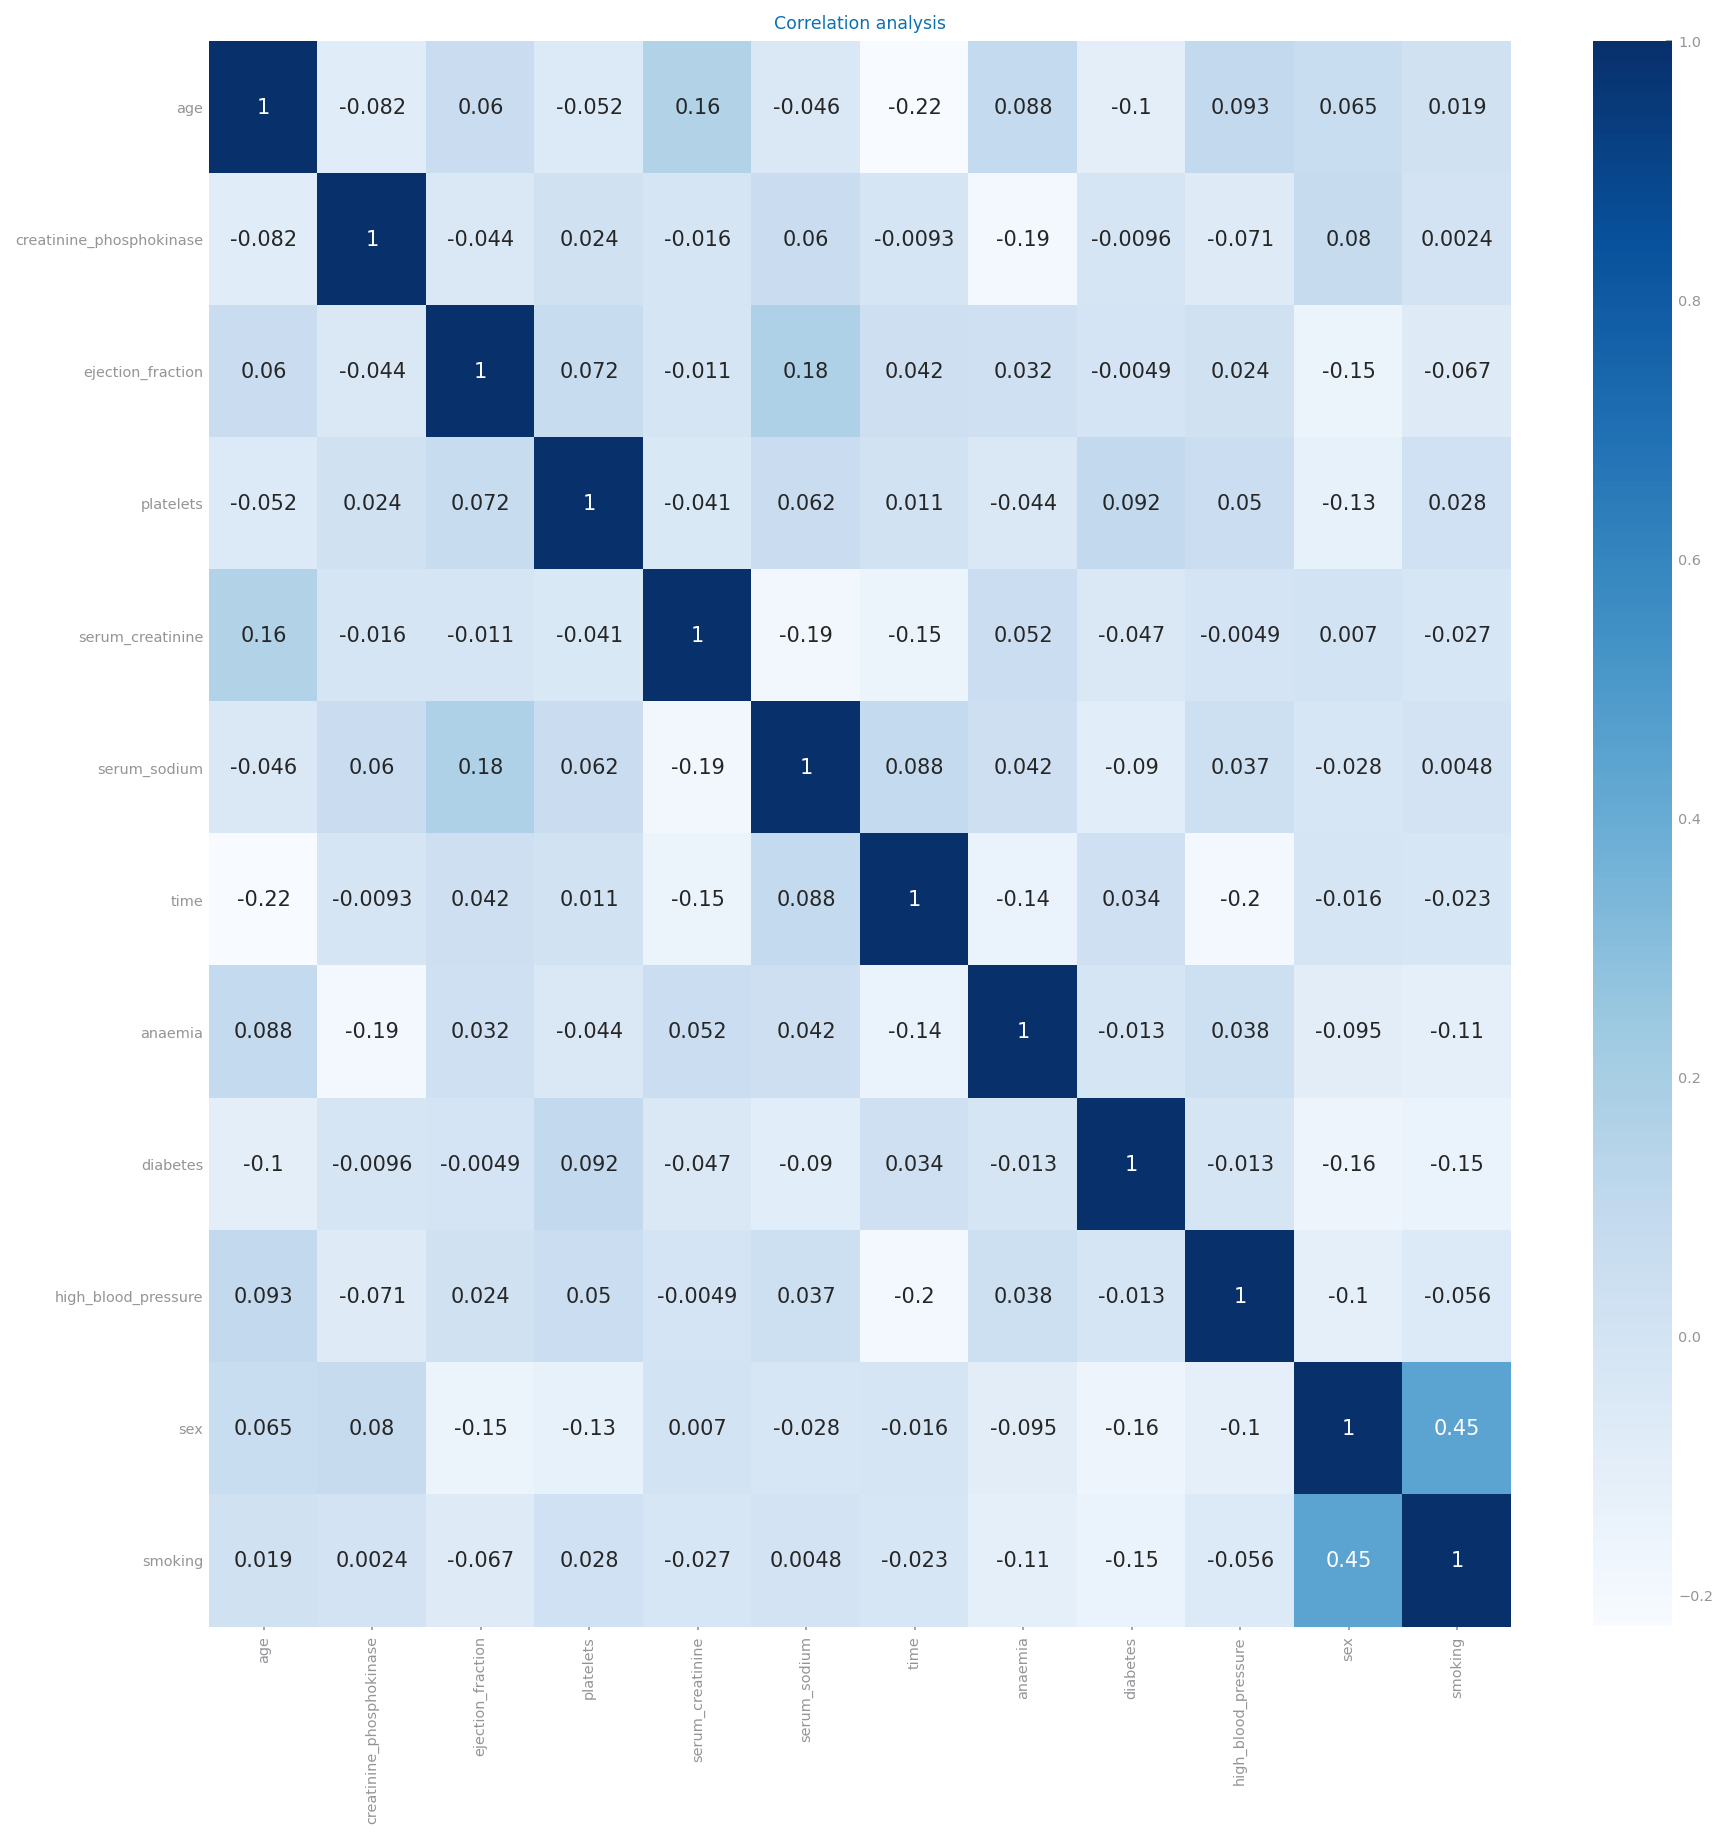

In [30]:
fig = plt.figure(figsize=[14,14])
corr_mtx = data.corr()
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

In terms of **redundancy** we didn't really note any highly correlated variables. The highest correlation is between smoking and sex, but even then the correlation didn't even surpass the 0.45

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

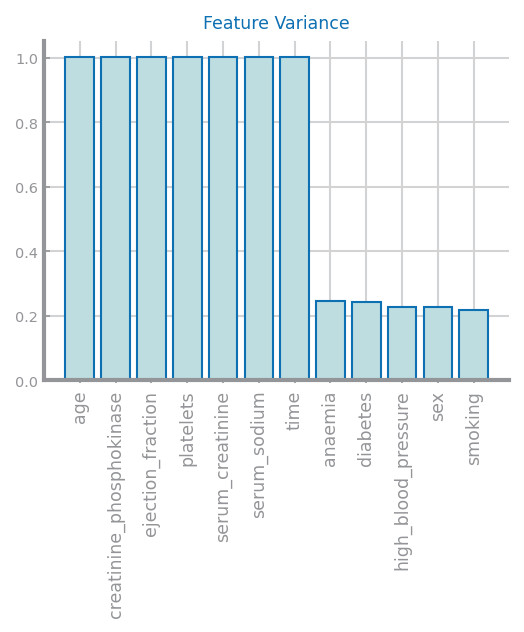

In [31]:
x_fs = []
y_fs = []
for i in data.columns:
    x_fs.append(data[i].var())
    y_fs.append(i)
    
plt.figure()
ds.bar_chart(y_fs, x_fs, title='Feature Variance')
plt.xticks(rotation=90)

All of our variables present some variance, although some do present a much smaller variation than others. Of note are **anemia**, **diabetes**, **high_blood_pressure**, **sex** and **smoking**. Even still we felt they didn't warrant getting removed purely due to the lack of variance (but we'll be looking out for these)

### Univariate Selection
"Statistical tests can be used to select those features that have the strongest relationship with the output variable." - https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. - https://scikit-learn.org/stable/modules/feature_selection.html

#### Pearson/Point-Biserial Correlation - Filter
"We check the absolute value of the **Pearson’s** correlation between the target and numerical features in our dataset. We keep the top n features based on this criterion." - https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

In [40]:
def cor_selector(X, y,threshold):
    cor_list = []
    feature_name = X.columns.tolist()
    
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))].columns.tolist()
    
    # remove features that have an absolute correlation value lower than the threshold
    temp_cor_list = []
    temp_cor_feature = []
    
    for i in range(0,len(cor_feature)):
        if(abs(cor_list[i]) > threshold):
            temp_cor_list.append(cor_list[i])
            temp_cor_feature.append(cor_feature[i])
        #else:
        #    print(cor_list[i])
        #    print(cor_feature[i])
    
    cor_list = temp_cor_list
    cor_feature = temp_cor_feature
        
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [41]:
threshold = 0.15

cor_support, cor_feature = cor_selector(X, y,threshold)
print(str(len(cor_feature)), 'Selected Features')
print(cor_feature)

5 Selected Features
['diabetes', 'smoking', 'creatinine_phosphokinase', 'anaemia', 'high_blood_pressure']


In [42]:
data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in cor_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_standardized_pearson.csv', index=False)
store_data.head()

,creatinine_phosphokinase,anaemia,diabetes,high_blood_pressure,smoking,DEATH_EVENT
0,0.000166,0,0,1,0,1
1,7.514640,0,0,0,0,1
2,-0.449939,0,0,0,1,1
3,-0.486071,1,0,0,0,1
4,-0.435486,1,1,0,0,1


#### ANOVA 
ANOVA is an acronym for “analysis of variance” and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not.

In [43]:
anova_selector = SelectKBest(f_classif)
anova_selector.fit(X, y)
anova_support = anova_selector.get_support()
anova_feature = X.loc[:,anova_support].columns.tolist()
print(str(len(anova_feature)), 'selected features')
print(anova_feature)

10 selected features
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia', 'high_blood_pressure', 'smoking']


In [44]:
data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in anova_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_standardized_anova.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,high_blood_pressure,smoking,DEATH_EVENT
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,0,1,0,1
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,0,0,0,1
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,0,0,1,1
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1,0,0,1
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1,0,0,1


#### Chi-Squared - Filter
CHI-Squared only works for non-negative values (which our standardized dataset posesses)

#### Recursive Feature Elimination (WIth SVR) - Wrapper
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. 

In [45]:
estimator = SVR(kernel="linear")

rfe_selector = RFE(estimator=estimator)
rfe_selector.fit(X, y)

rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

6 selected features
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'time', 'sex']


In [46]:
data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in rfe_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_standardized_rfe.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,time,sex,DEATH_EVENT
0,1.192945,0.000166,-1.530560,0.490057,-1.629502,1,1
1,-0.491279,7.514640,-0.007077,-0.284552,-1.603691,1,1
2,0.350833,-0.449939,-1.530560,-0.090900,-1.590785,1,1
3,-0.912335,-0.486071,-1.530560,0.490057,-1.590785,1,1
4,0.350833,-0.435486,-1.530560,1.264666,-1.577879,0,1


#### Lasso
Allegedly really good for when you have both categorical and numeric features - https://datascience.stackexchange.com/questions/68792/feature-selection-for-data-with-both-continuous-and-categorical-features

This is an Embedded method. As said before, Embedded methods use algorithms that have built-in feature selection methods.

For example, Lasso and RF have their own feature selection methods. Lasso Regularizer forces a lot of feature weights to be zero.

In [47]:
estimator = SVR(kernel="linear")

embeded_lr_selector = SelectFromModel(estimator, max_features=10)
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
print(embeded_lr_feature)

4 selected features
['age', 'ejection_fraction', 'serum_creatinine', 'time']


In [48]:
data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in embeded_lr_feature and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_standardized_lasso.csv', index=False)
store_data.head()

,age,ejection_fraction,serum_creatinine,time,DEATH_EVENT
0,1.192945,-1.530560,0.490057,-1.629502,1
1,-0.491279,-0.007077,-0.284552,-1.603691,1
2,0.350833,-1.530560,-0.090900,-1.590785,1
3,-0.912335,-1.530560,0.490057,-1.590785,1
4,0.350833,-1.530560,1.264666,-1.577879,1


#### Mixing

In [49]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':X.columns.tolist(), 'Pearson':cor_support, 'ANOVA': anova_support, 'RFE':rfe_support, 'Lasso': embeded_lr_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(12)

,Feature,Pearson,ANOVA,RFE,Lasso,Total
1,time,False,True,True,True,3
2,serum_creatinine,False,True,True,True,3
3,ejection_fraction,False,True,True,True,3
4,creatinine_phosphokinase,True,True,True,False,3
5,age,False,True,True,True,3
6,smoking,True,True,False,False,2
7,high_blood_pressure,True,True,False,False,2
8,anaemia,True,True,False,False,2
9,sex,False,False,True,False,1
10,serum_sodium,False,True,False,False,1


In [50]:
data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

feature_selection_df.drop(feature_selection_df[feature_selection_df.Total < 3].index, inplace=True)

store_data = data.copy()
for col in data.columns.tolist():
    if col not in feature_selection_df['Feature'].tolist() and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/univariate/HR_standardized_mixed.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,time,DEATH_EVENT
0,1.192945,0.000166,-1.530560,0.490057,-1.629502,1
1,-0.491279,7.514640,-0.007077,-0.284552,-1.603691,1
2,0.350833,-0.449939,-1.530560,-0.090900,-1.590785,1
3,-0.912335,-0.486071,-1.530560,0.490057,-1.590785,1
4,0.350833,-0.435486,-1.530560,1.264666,-1.577879,1


### Feature Importance
"Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable."

"Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top features for the dataset."

-https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

[0.09628984 0.07881358 0.12851647 0.06973175 0.11833295 0.09137541
 0.27972475 0.02687715 0.03059311 0.02422816 0.02704599 0.02847083]


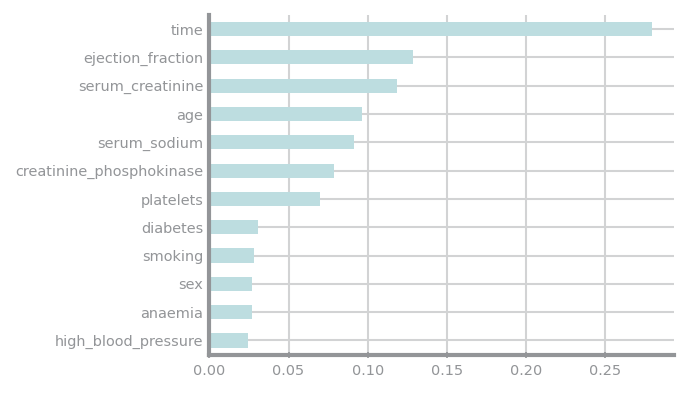

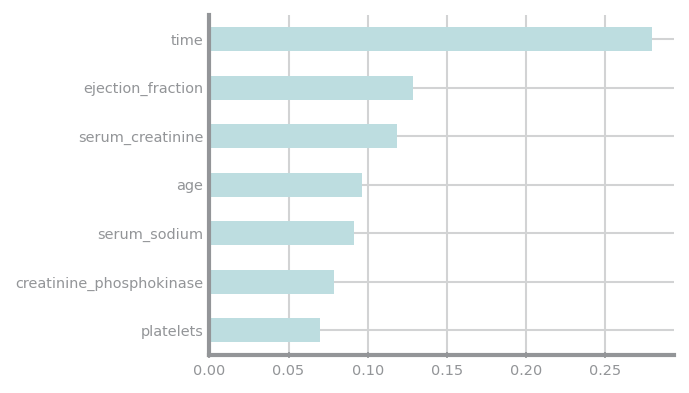

In [51]:
data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

y = data.pop('DEATH_EVENT')
X = data

model = ExtraTreesClassifier()
model.fit(X,y)

print(model.feature_importances_) #Use inbuilt class feature_importances of tree based classifiers

#Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh')
plt.show()

#Remove features with importance under 0.05
feat_importances.drop(feat_importances[feat_importances.values < 0.05].index, inplace=True)

feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh')
plt.show()

In [52]:
data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

store_data = data.copy()
for col in data.columns.tolist():
    if col not in feat_importances.index.tolist() and col != "DEATH_EVENT":
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/importance/HR_standardized_extraTreeClassifier.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,1
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,1
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,1
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1


### Correlation Matrix

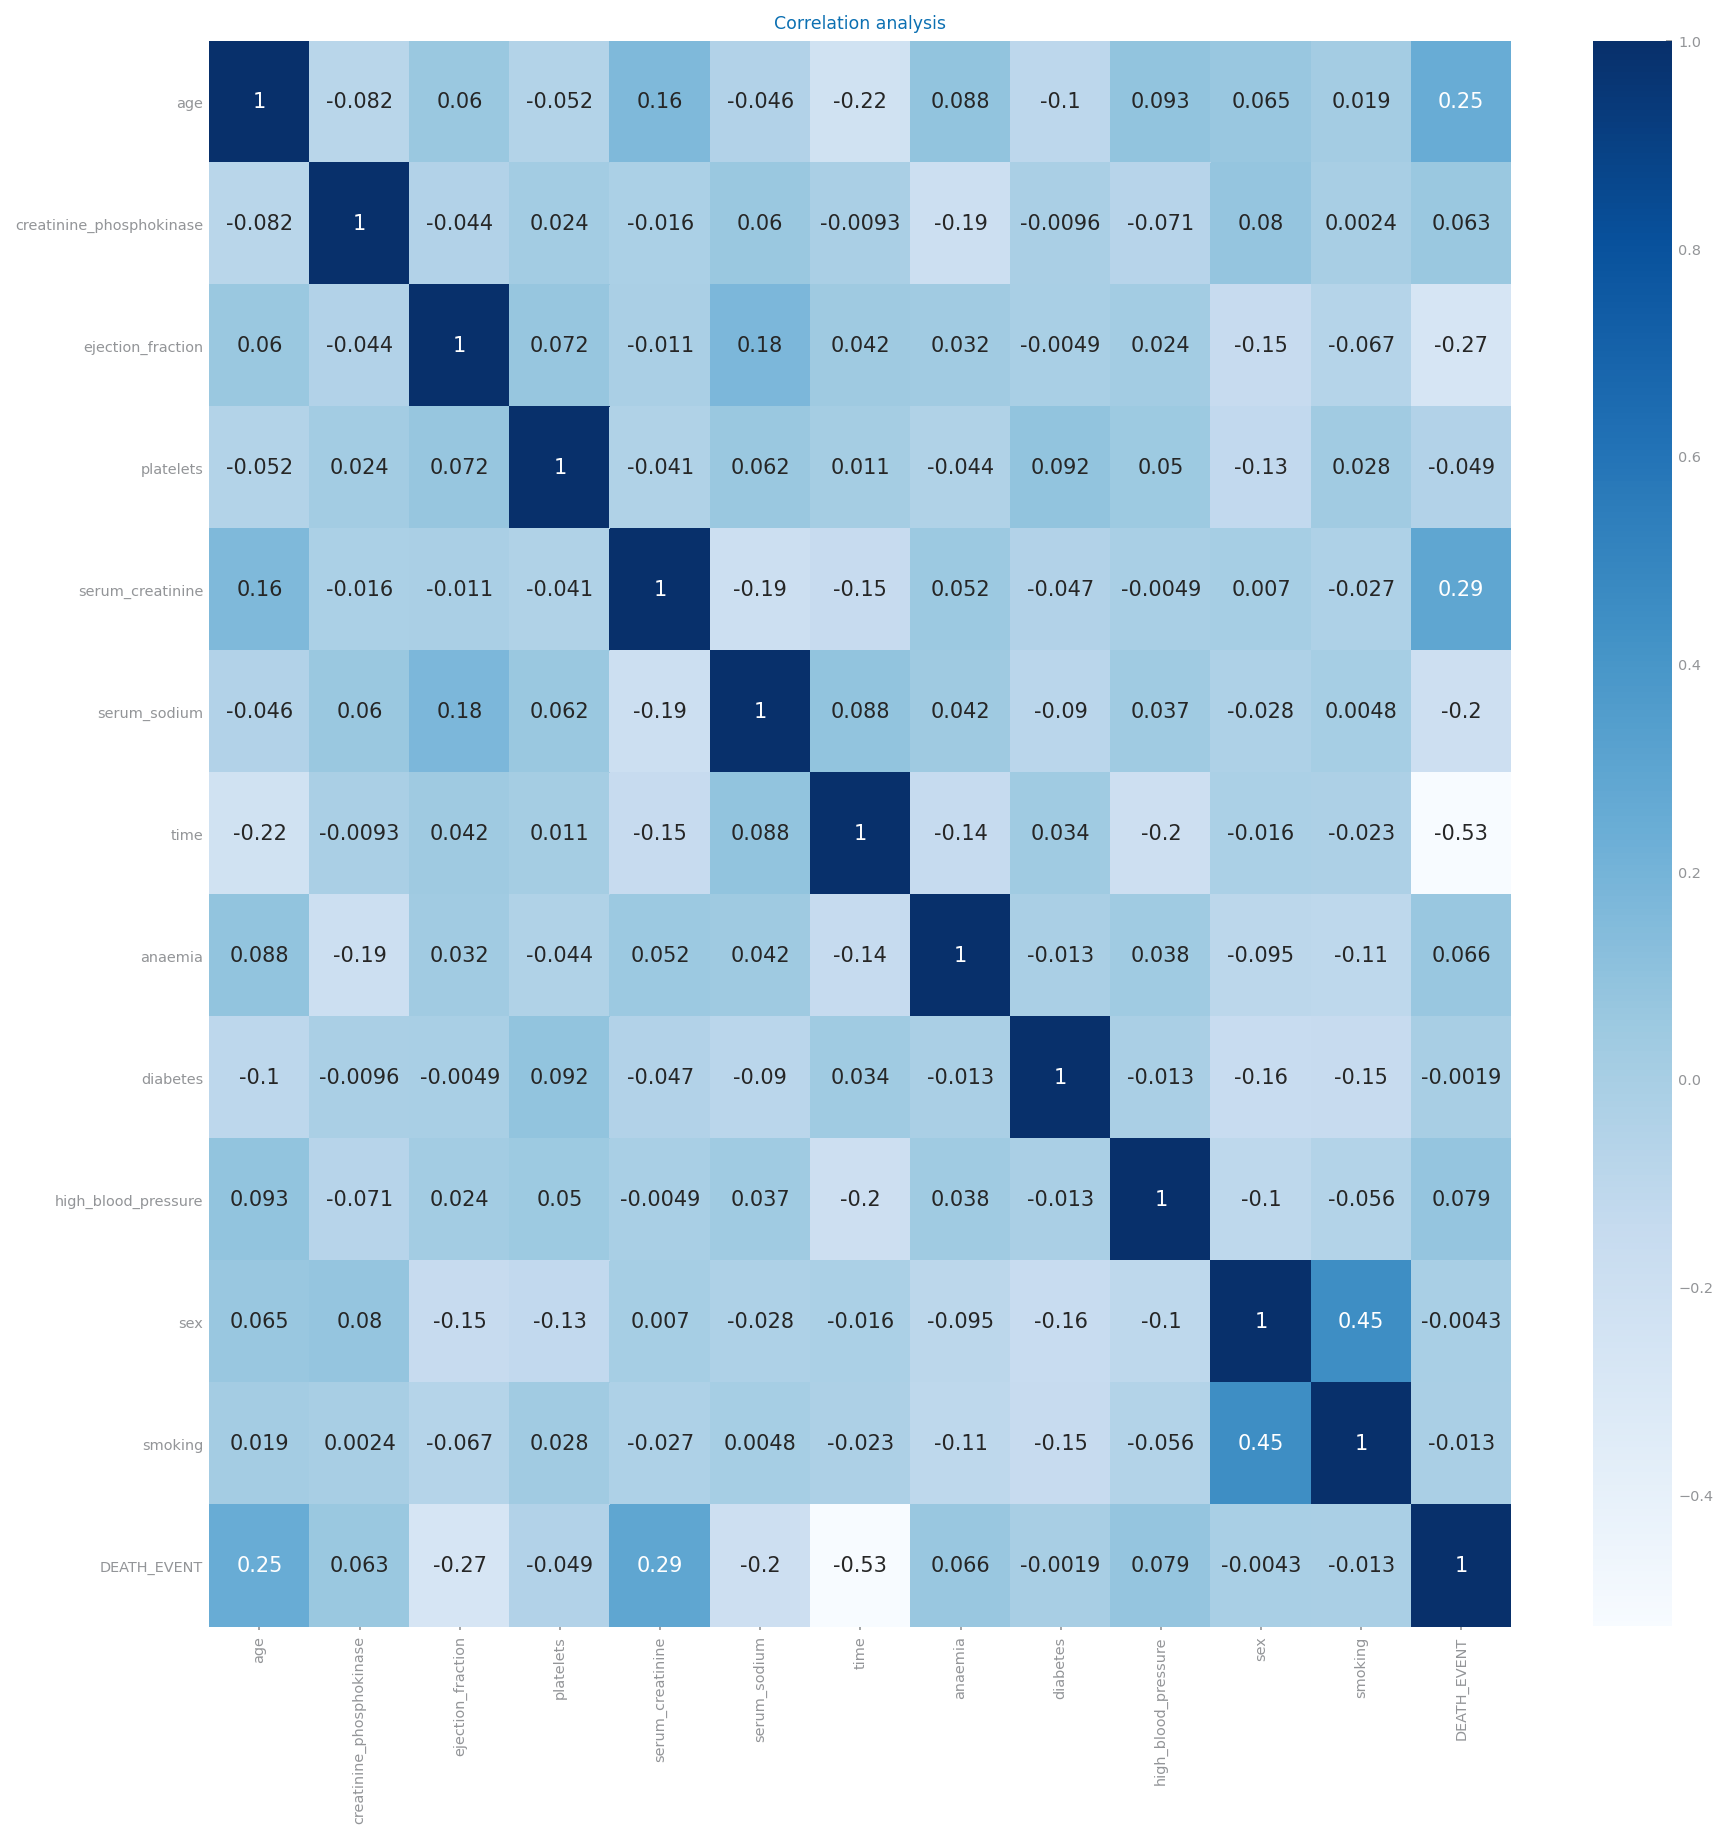

In [53]:
data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

fig = plt.figure(figsize=[14,14])
corr_mtx = data.corr()
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

By analyzing this heatmap we can note that there are two specific variables that correlate very little to the target variable - DEATH_EVENT

These are - **diabetes** and **sex**

In [54]:
corr_mtx = data.corr()
corr_mtx.drop(corr_mtx.head(12).index,inplace=True) 

temp_feature = []

#Remove all features whose correlation to our target variable is smaller than 0.01
for i in corr_mtx.columns:
    if(abs(corr_mtx[i].values) > 0.01):
        temp_feature.append(i)
        
print(str(len(temp_feature)), 'selected features (features + target)')
print(temp_feature)

11 selected features (features + target)
['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']


In [55]:
data = pd.read_csv('../datasets/hf_scaled/HF_standardized.csv')

feature_selection_df.drop(feature_selection_df[feature_selection_df.Total < 3].index, inplace=True)

store_data = data.copy()
for col in data.columns.tolist():
    if col not in temp_feature:
        store_data.drop(col, axis=1, inplace=True)

store_data.to_csv(r'../datasets/hf_feature_engineering/feature_selection/correlation/HR_standardized_corr.csv', index=False)
store_data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,high_blood_pressure,smoking,DEATH_EVENT
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,0,1,0,1
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,0,0,0,1
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,0,0,1,1
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1,0,0,1
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1,0,0,1
